## **Regression Model for House Price Prediction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Step 1: Loading the dataset

In [60]:
# Loading the dataset
df = pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [61]:
# Inspecting the dataset
print("Shape:", df.shape)
print("**************")
print("Dataset Information:")
print(df.info())
print("**************")
print("Missing Values:\n", df.isnull().sum())
print("**************")
print("Duplicate Rows:", df.duplicated().sum())
print("**************")
print("Summary Statistics for Numerical Fields:\n", df.describe())

Shape: (545, 13)
**************
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None
**************
Missing Values:
 price               0
area                0
bedrooms            

There are no missing values.

Visualizing Distributions and Outliers:

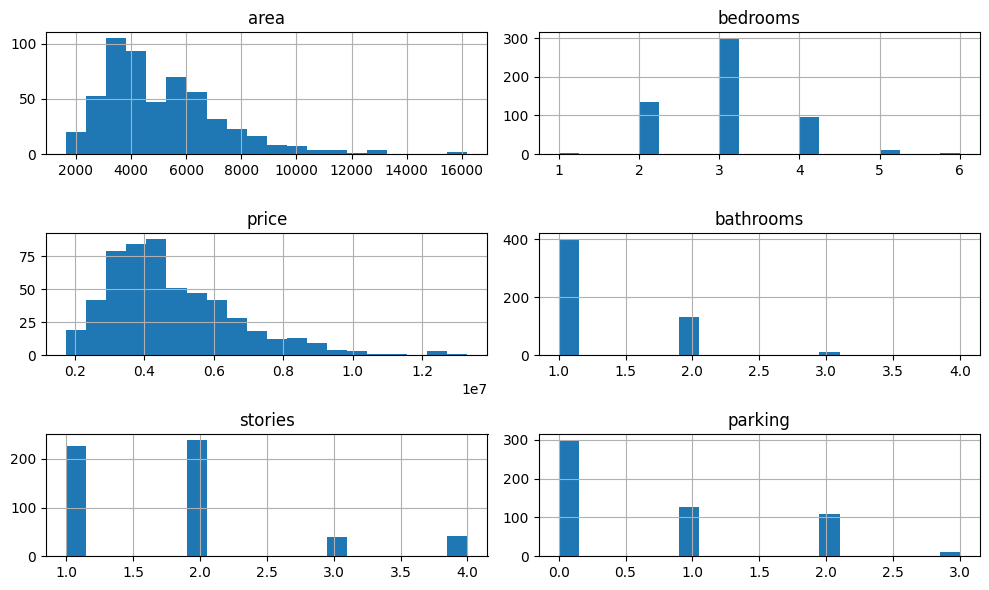

In [62]:
# Histograms for Area, Price, no. of bedrooms
df[['area', 'bedrooms', 'price', 'bathrooms', 'stories', 'parking']].hist(bins=20, figsize=(10,6))
plt.tight_layout()
plt.show()

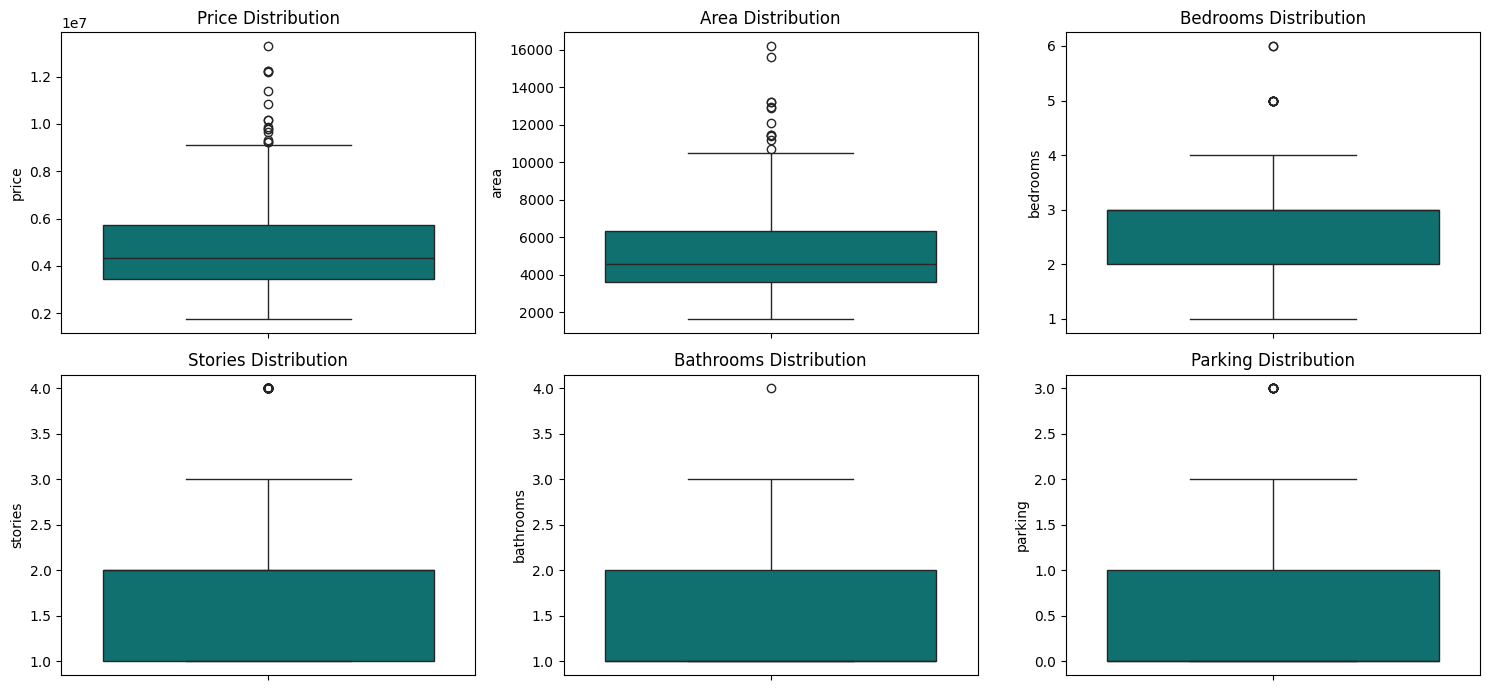

In [63]:
# Boxplot for Outliers

fig, axes = plt.subplots(2, 3, figsize=(15,7))
# Price
sns.boxplot(data=df['price'], ax=axes[0][0], color='teal')
axes[0][0].set_title("Price Distribution")

# Area
sns.boxplot(data=df['area'], ax=axes[0][1], color='teal')
axes[0][1].set_title("Area Distribution")

# Bedrooms
sns.boxplot(data=df['bedrooms'], ax=axes[0][2], color='teal')
axes[0][2].set_title("Bedrooms Distribution")

# Stories
sns.boxplot(data=df['stories'], ax=axes[1][0], color='teal')
axes[1][0].set_title("Stories Distribution")

# Bathrooms
sns.boxplot(data=df['bathrooms'], ax=axes[1][1], color='teal')
axes[1][1].set_title("Bathrooms Distribution")

# Parking
sns.boxplot(data=df['parking'], ax=axes[1][2], color='teal')
axes[1][2].set_title("Parking Distribution")

plt.tight_layout()
plt.show()

Step 2: Data Pre-processing

In [64]:
# Normalizing the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = ['area', 'price', 'bedrooms', 'stories', "parking", 'bathrooms']
df[cols] = scaler.fit_transform(df[cols])

In [65]:
# Encoding binary data
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df[binary_cols] = df[binary_cols].replace({'yes':1, 'no':0})

# One-hot encoding categorical data
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True, dtype=int)
# Since knowing two of the dummy columns automatically gives you the third, it leads to redundancy.
# The model infers the dropped category when both other dummies are 0.
# Therefore, the use of drop_first Prevents multicollinearity, Reduces unnecessary feature columns and Makes regression models more stable

/tmp/ipython-input-4275323328.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace({'yes':1, 'no':0})


Step 3: Feature Selection

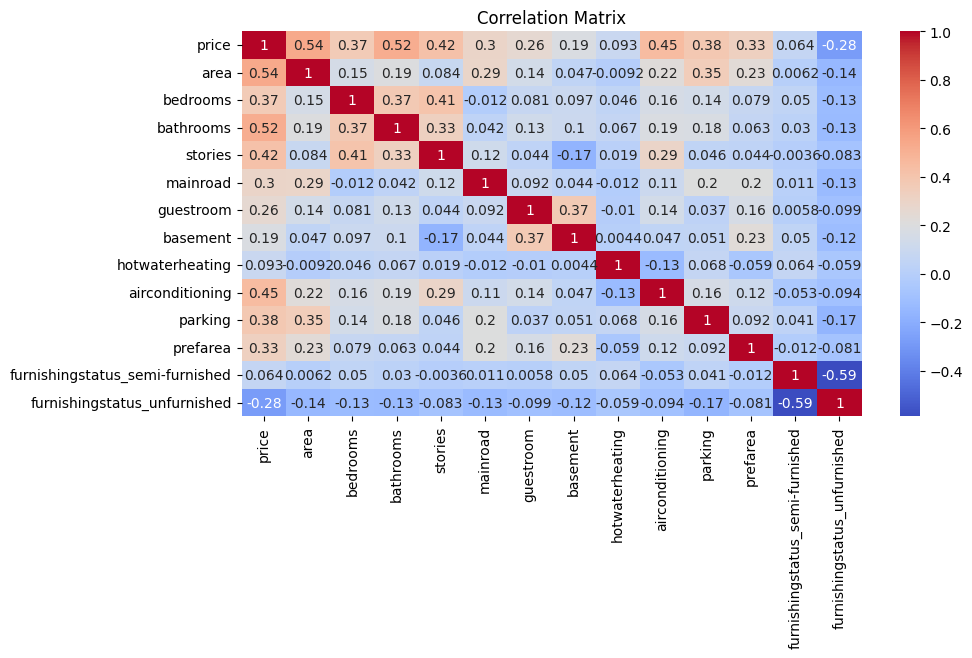

In [66]:
# Correlation Matrix

corr_matrix = df.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [68]:
# Making a dataframe only with columns that are highly correlated to 'price'
final_df = pd.DataFrame()
final_df['price'] = df['price']

# Keeping a threshold of 0.25
for col in df.columns:
  if col!='price' and abs(corr_matrix['price'][col]) > 0.25:
    final_df[col] = df[col]

In [69]:
final_df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,airconditioning,parking,prefarea,furnishingstatus_unfurnished
0,1.000000,0.396564,0.6,0.333333,0.666667,1,0,1,0.666667,1,0
1,0.909091,0.502405,0.6,1.000000,1.000000,1,0,1,1.000000,0,0
2,0.909091,0.571134,0.4,0.333333,0.333333,1,0,0,0.666667,1,0
3,0.906061,0.402062,0.6,0.333333,0.333333,1,0,1,1.000000,1,0
4,0.836364,0.396564,0.6,0.000000,0.333333,1,1,1,0.666667,0,0


Step 4: Model Training

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = final_df.drop('price', axis=1)
y = final_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Step 5: Model Evaluation

In [76]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 0.01
R-squared: 0.64


In [73]:
# Feature Importance

coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

coeff_df

,Feature,Coefficient
2,bathrooms,0.296559
0,area,0.286609
3,stories,0.091348
6,airconditioning,0.067809
7,parking,0.062755
8,prefarea,0.058803
1,bedrooms,0.048064
5,guestroom,0.035455
4,mainroad,0.033009
9,furnishingstatus_unfurnished,-0.033239


## **Insights**
- **Most Important Predictors:** The most influential features on house price are the area and the number of bathrooms.

- **Other Key Factors:** The number of stories, presence of air conditioning, and available parking also significantly impact the price.

- **Price Boosters:** Larger area, more bathrooms, stories, air conditioning, parking, and a preferred location all tend to increase the house price.

- **Price Reducers:** A house being unfurnished is linked to a lower price.

- **Model Performance:** The model explains 64% of the price variation (R-squared of 0.64).

- **Model Reliability:** It serves as a good baseline for price prediction but isn't perfectly accurate, as other real-world factors also affect pricing.